In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

Using TensorFlow backend.


In [2]:
dataDir = "/home/trojan/Desktop/dimentia/DCGAN/dataset/"

dataset = keras.preprocessing.image_dataset_from_directory(
    dataDir, label_mode=None, image_size=(256, 256), batch_size=2
)
dataset = dataset.map(lambda x: x / 255.0)



Found 4919 files belonging to 1 classes.


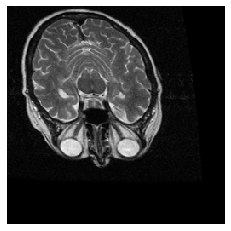

In [3]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break


In [4]:
discriminator = keras.Sequential(
    [
        layers.GaussianNoise(0.2, input_shape = [256, 256, 3]),
        layers.Conv2D(8, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(16, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(32, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(128),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 8)       392       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        2064      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        8224      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)      

In [5]:
latent_dim = 4096

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Reshape((1, 1, 4096)),
        layers.Conv2DTranspose(1024, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(16, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(8, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()


Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 1, 4096)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 2, 2, 1024)        67109888  
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 2, 2, 1024)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 512)         8389120   
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 256)         2097408   
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 256)         0 

In [6]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [7]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=1024): # 4096
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_images/generated_img_%03d_%d.png" % (epoch, i))


In [8]:
epochs = 100  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=1, latent_dim=latent_dim)]
)


Epoch 1/100
2460/2460 [==============================] - 302s 123ms/step - d_loss: 1092.9556 - g_loss: 309331.7188
Epoch 2/100
2460/2460 [==============================] - 305s 124ms/step - d_loss: 138.5237 - g_loss: 114508.6406
Epoch 3/100
2460/2460 [==============================] - 307s 125ms/step - d_loss: -13.0597 - g_loss: 1654.6301
Epoch 4/100
2460/2460 [==============================] - 308s 125ms/step - d_loss: -64.1721 - g_loss: 6861.8765
Epoch 5/100
2460/2460 [==============================] - 309s 126ms/step - d_loss: -13.5712 - g_loss: 8122.8887
Epoch 6/100
2460/2460 [==============================] - 310s 126ms/step - d_loss: -884.7678 - g_loss: 399917.9062
Epoch 7/100
2460/2460 [==============================] - 310s 126ms/step - d_loss: 25.1805 - g_loss: 6066.5132
Epoch 8/100
2460/2460 [==============================] - 310s 126ms/step - d_loss: -582.3546 - g_loss: 229874.1406
Epoch 9/100
2460/2460 [==============================] - 310s 126ms/step - d_loss: -1.2353 - g

KeyboardInterrupt: 